# Foundations of Data Mining: Assignment 2

Please complete all assignments in this notebook. You should submit this notebook, as well as a PDF version (See File > Download as).

In [1]:
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 100 # This controls the size of your figures
# Comment out and restart notebook if you only want the last output of each cell.
InteractiveShell.ast_node_interactivity = "none" 

In [2]:
# This is a temporary read-only OpenML key. Replace with your own key later. 
oml.config.apikey = '11e82c8d91c5abece86f424369c71590'

## Robots and SVMs (4 points (2+1+1))

The [Wall Robot Navigation dataset](http://www.openml.org/d/1497) contains about 5500 readings of an ultrasound sensor array mounted on a robot, and your task is to finetune and train an SVM classifier to predict how the robot should move next.

- Make a stratified 80-20 split of the data. On the training set alone, optimize the main hyperparameters of the SVM for Accuracy with a random search. Vary at least the main kernel types (linear, polynomial, and RBF), the C parameter, the $\gamma$ parameter for the RBF kernel and the exponent/degree for the polynomial kernel. Report the optimal hyperparameter settings and Accuracy performance. 
    - The degree of the polynonial is typically in the range 2..10.
    - Hint: note that the hyperparameter ranges depend on each other. For instance, $\gamma$ only makes sense if you have selected the RBF kernel as well. We've seen in class how to define multiple hyperparameter spaces in a random/grid search.
- Use a 5x3-fold (5 outer, 3 inner) nested cross-validation (CV) on the **whole** dataset to obtain a clean evaluation. What is the mean optimized performance? Is this in line with the optimized result of the random search of the previous question?
- Train an SVM using the optimal hyperparameter configuration you found (in part 1 of this question) and test it on the held out (20%) test set. Compare this Accuracy result with the (mean) result of the nested CV. If you would build this robot in practice, how would you find the hyperparameters to use, and which performance would you expect? Is it truly necessary to tune the hyperparameters? Which hyperparameters were most important to tune?

In [3]:
robot_data = oml.datasets.get_dataset(1497) # Download Robot data
# Get the predictors X and the labels y
X, y = robot_data.get_data(target=robot_data.default_target_attribute)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import cross_val_score
from scipy.stats import expon
from sklearn import svm


In [5]:
def extract_value(info, key):
    if key in info:
        return info[key]
    return 'Na'


def create_dataframe(results):
    items = []
    for result in results:
        info = []
        info.append(result[0]['C'])
        info.append(extract_value(result[0], 'gamma'))
        info.append(extract_value(result[0], 'coef0'))
        info.append(extract_value(result[0], 'degree'))
        info.append(result[1])
        items.append((result[0]['kernel'], info))
        
    return pd.DataFrame.from_items(items, orient='index', 
                                   columns=['C', 'r', 'gamma', 'degree', 'accuracy'])

def select_best(results):
    best_accuracy = 0.0
    best_params = None
    
    for result in results:
        if result[1] > best_accuracy:
            best_accuracy = result[1]
            best_params = result[0]
    
    return (best_params, best_accuracy)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,
                                                    random_state=0,stratify=y)

param_grid = [
    {'kernel': ['linear'], 
     'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
    {'kernel': ['poly'],
     'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
     'degree': np.arange(2,11).tolist(),
     'coef0': [1.0/16, 1.0/8, 1.0/4, 1.0/2, 1.0, 2, 4, 8, 16, 32]},
    {'kernel': ['rbf'], 
     'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 
     'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
    {'kernel': ['sigmoid'],
     'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
     'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
     'coef0': [1.0/16, 1.0/8, 1.0/4, 1.0/2, 1.0, 2, 4, 8, 16, 32]}
 ]

n_iter_search = 6
random_search_results = []
clf_performances = []

for params in param_grid:
    random_search = RandomizedSearchCV(svm.SVC(),
                                       param_distributions=params,
                                       n_iter=n_iter_search,
                                       scoring='accuracy',
                                       cv=5)
    random_search.fit(X_train, y_train)
    
    clf_performances.append((random_search.best_params_,
                           random_search.best_score_))
    
    random_search_results.append(
        {
            random_search.best_params_['kernel'] :
            random_search.cv_results_
        }
    )
    

### Optimal hyperparameters settings and accuracy performance

In [7]:
svm_best_parameters, best_accuracy = select_best(clf_performances)
df = create_dataframe(clf_performances)
display(df)
print("Optimal hyperparameters: {}".format(svm_best_parameters))
print("Accuracy performance: {:.2f}".format(best_accuracy))

,C,r,gamma,degree,accuracy
linear,1.00e+01,Na,Na,Na,0.73
poly,1.00e-04,Na,4,6,0.91
rbf,1.00e+02,0.01,Na,Na,0.92
sigmoid,1.00e-01,100,0.062,Na,0.40


Optimal hyperparameters: {'gamma': 0.01, 'C': 100, 'kernel': 'rbf'}
Accuracy performance: 0.92


In [8]:

def construct_grid_params(best_parameters):
    variable_param = []
    grid_params = []
    if best_parameters['kernel'] == 'poly':
        grid_params.append({
                'kernel': ['poly'],
                'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                'degree': [best_parameters['degree']],#*8,
                'coef0': [best_parameters['coef0']],#*8
            })
        variable_param.append('param_C')
        
        grid_params.append({
                'kernel': ['poly'],
                'C': [best_parameters['C']],#*9,
                'degree': np.arange(2,11).tolist(),
                'coef0': [best_parameters['coef0']],#*9                
            })
        variable_param.append('param_degree')
        
        grid_params.append({
                'kernel': ['poly'],
                'C': [best_parameters['C']],#*10,
                'degree': [best_parameters['degree']],#*10,
                'coef0': [1.0/16, 1.0/8, 1.0/4, 1.0/2, 1.0, 2, 4, 8, 16, 32]                                
            })
        variable_param.append('param_coef0') 
    
    elif best_parameters['kernel'] == 'rbf':
        grid_params.append({
                'kernel': ['rbf'],
                'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                'gamma': [best_parameters['gamma']],#*8
            })
        variable_param.append('param_C')
        
        grid_params.append({
                'kernel': ['rbf'],
                'C': [best_parameters['C']],#*8,
                'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]                
            })
        variable_param.append('param_gamma')
    
    elif best_parameters['kernel'] == 'sigmoid':
        grid_params.append({
                'kernel': ['sigmoid'],
                'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                'gamma': [best_parameters['gamma']],#*8,
                'coef0': [best_parameters['coef0']],#*8
            })
        variable_param.append('param_C')
        
        grid_params.append({
                'kernel': ['sigmoid'],
                'C': [best_parameters['C']],#*8,
                'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                'coef0': [best_parameters['coef0']],#*8                
            })
        variable_param.append('param_gamma')
        
        grid_params.append({
                'kernel': ['sigmoid'],
                'C': [best_parameters['C']],#*10,
                'gamma': [best_parameters['gamma']],#*10,
                'coef0': [1.0/16, 1.0/8, 1.0/4, 1.0/2, 1.0, 2, 4, 8, 16, 32]                                
            })
        variable_param.append('param_coef0')
    
    return (grid_params, variable_param)

def extract_variable(parameters):
    variable = []
    for key in parameters:
        if len(parameters[key]) > 1:
            variable = parameters[key]
    return variable


In [9]:
ev_grid_params, variable_param = construct_grid_params(svm_best_parameters)
cv_results = []

for index, grid_param in enumerate(ev_grid_params):
    
    grid_search = GridSearchCV(svm.SVC(), grid_param, scoring='accuracy', cv=5)
    grid_search.fit(X_train, y_train)
    
    cv_results.append({variable_param[index]:{'mean_test_score':
                                              grid_search.cv_results_["mean_test_score"],
                                              'variable_values':
                                              extract_variable(grid_param)
                                             }})

### Visualizing hyperparameter impact

In [10]:
def create_plot(parameters, fig):
    var_name = list(parameters.keys())[0]
    content = parameters[var_name]
    var_value = content['variable_values']
    mean_test_scores = content['mean_test_score']
    if (var_name == 'param_C' or var_name == 'param_gamma'):
        plt.semilogx(var_value, mean_test_scores)
    else:
        plt.plot(var_value, mean_test_scores)
    plt.legend(["variable: " + var_name], loc="upper left")
    plt.figure(fig)
    plt.show()
    

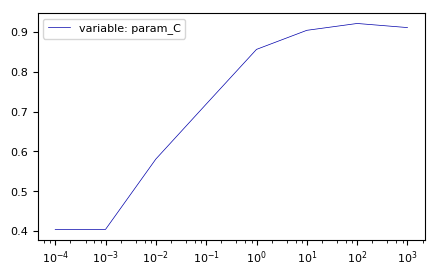

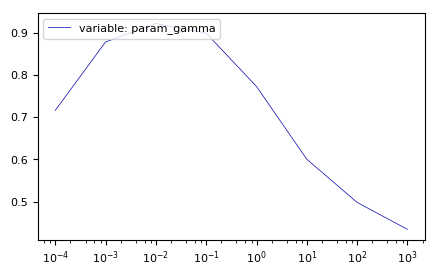

In [11]:
labels = []
for index, element in enumerate(cv_results):
  create_plot(element, index)

In [12]:
results = []

for params in param_grid:
    scores= cross_val_score(RandomizedSearchCV(svm.SVC(), 
                                               param_distributions=params,
                                               n_iter=n_iter_search,
                                               scoring='accuracy',
                                               cv=3),
                                           X, y, cv=5)
    
    results.append((params['kernel'], scores.mean()))

best_kernel, best_mean_accuracy = select_best(results)


### 5x3-fold nested cross-validation results

In [13]:
print("Mean accuracy for nested cross-validation: {:.2f}".format(best_mean_accuracy))

Mean accuracy for nested cross-validation: 0.87


The accuracy obtained from the random search is better than the mean optimized performance obtained with cross validation. Random search seems to perform better than cross validation, but the difference between performance values is small, and cross validation works over different training/test sets while random search does not (this time it seems like it got a nice training/test split).We think the results from cross validation and random search are in line.

### Held out test set results

In [14]:
opt_svm = svm.SVC(**svm_best_parameters)
opt_svm.fit(X_train, y_train)
score = opt_svm.score(X_test, y_test)
print("Computed score on test set: {:.2f}".format(score))

Computed score on test set: 0.93


The accuracy result of the held out test set is better than the results from cross validation.

In practice we could use nested cross validation implemented from scratch to retrieve the best hyperparameters trained using grid search or random search.

I would expect a performance better than 0.90

The graphs from before show that parameter C affects the svm's peformance more than the other parameters.